https://www.kaggle.com/code/gauravduttakiit/pyod-a-python-toolkit-for-outlier-detection

In [3]:
pip install pyod

     -------------------------------------- 153.4/153.4 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 2.6/2.6 MB 33.3 MB/s eta 0:00:00
     --------------------------------------- 28.1/28.1 MB 13.9 MB/s eta 0:00:00
Using legacy 'setup.py install' for pyod, since package 'wheel' is not installed.
  Running setup.py install for pyod: started
  Running setup.py install for pyod: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from __future__ import division
from __future__ import print_function
import os
import sys
from time import time
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager 

In [4]:
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA 

In [5]:
num_samples = 5000
from random import randrange
out_frac=randrange(0,45)/100
out_frac

0.26

In [6]:
clusters_separation = [0]
x, y = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
"""
(1 - fraction of outliers) will give the fraction of inliers; multiplying  it with the total number #of samples will give number of inliers
"""
num_inliers = int((1. - out_frac) * num_samples)
"""
Multiply fraction of outliers with total number of samples to compute number of outliers
"""
num_outliers = int(out_frac * num_samples)
"""
Create ground truth array with 0 and 1 representing outliers and inliers respectively
"""
ground_truth = np.zeros(num_samples, dtype=int)
ground_truth[-num_outliers:] = 1 

In [7]:
print('No. of inliers: %i' % num_inliers)
print('No. of outliers: %i' % num_outliers)
print('Ground truth arrayy shape is {shape}. Outlier are 1 and inlier are 0.\n'.format(shape=ground_truth.shape))
print(ground_truth) 

No. of inliers: 3700
No. of outliers: 1300
Ground truth arrayy shape is (5000,). Outlier are 1 and inlier are 0.

[0 0 0 ... 1 1 1]


In [8]:
rs = np.random.RandomState(42)  #random state
 #dictionary of classifiers
clf = { 
    'Angle-based Outlier Detector (ABOD)': ABOD(contamination=out_frac),
    'Cluster-based Local Outlier Factor (CBLOF)': CBLOF(contamination=out_frac,check_estimator=False, random_state=rs),
    'Isolation Forest': IForest(contamination=out_frac,random_state=rs),
    'K Nearest Neighbors (KNN)': KNN(contamination=out_frac),
    'Average KNN': KNN(method='mean', contamination=out_frac),
    'Local Outlier Factor (LOF)':LOF(n_neighbors=35, contamination=out_frac),
    'One-class SVM (OCSVM)': OCSVM(contamination=out_frac),
    'Principal Component Analysis (PCA)': PCA(contamination=out_frac, random_state=rs),
} 

In [9]:
for i, classifier in enumerate(clf.keys()):
    print('Model', i + 1, classifier) 

Model 1 Angle-based Outlier Detector (ABOD)
Model 2 Cluster-based Local Outlier Factor (CBLOF)
Model 3 Isolation Forest
Model 4 K Nearest Neighbors (KNN)
Model 5 Average KNN
Model 6 Local Outlier Factor (LOF)
Model 7 One-class SVM (OCSVM)
Model 8 Principal Component Analysis (PCA)


c:\Users\Luan Lima\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


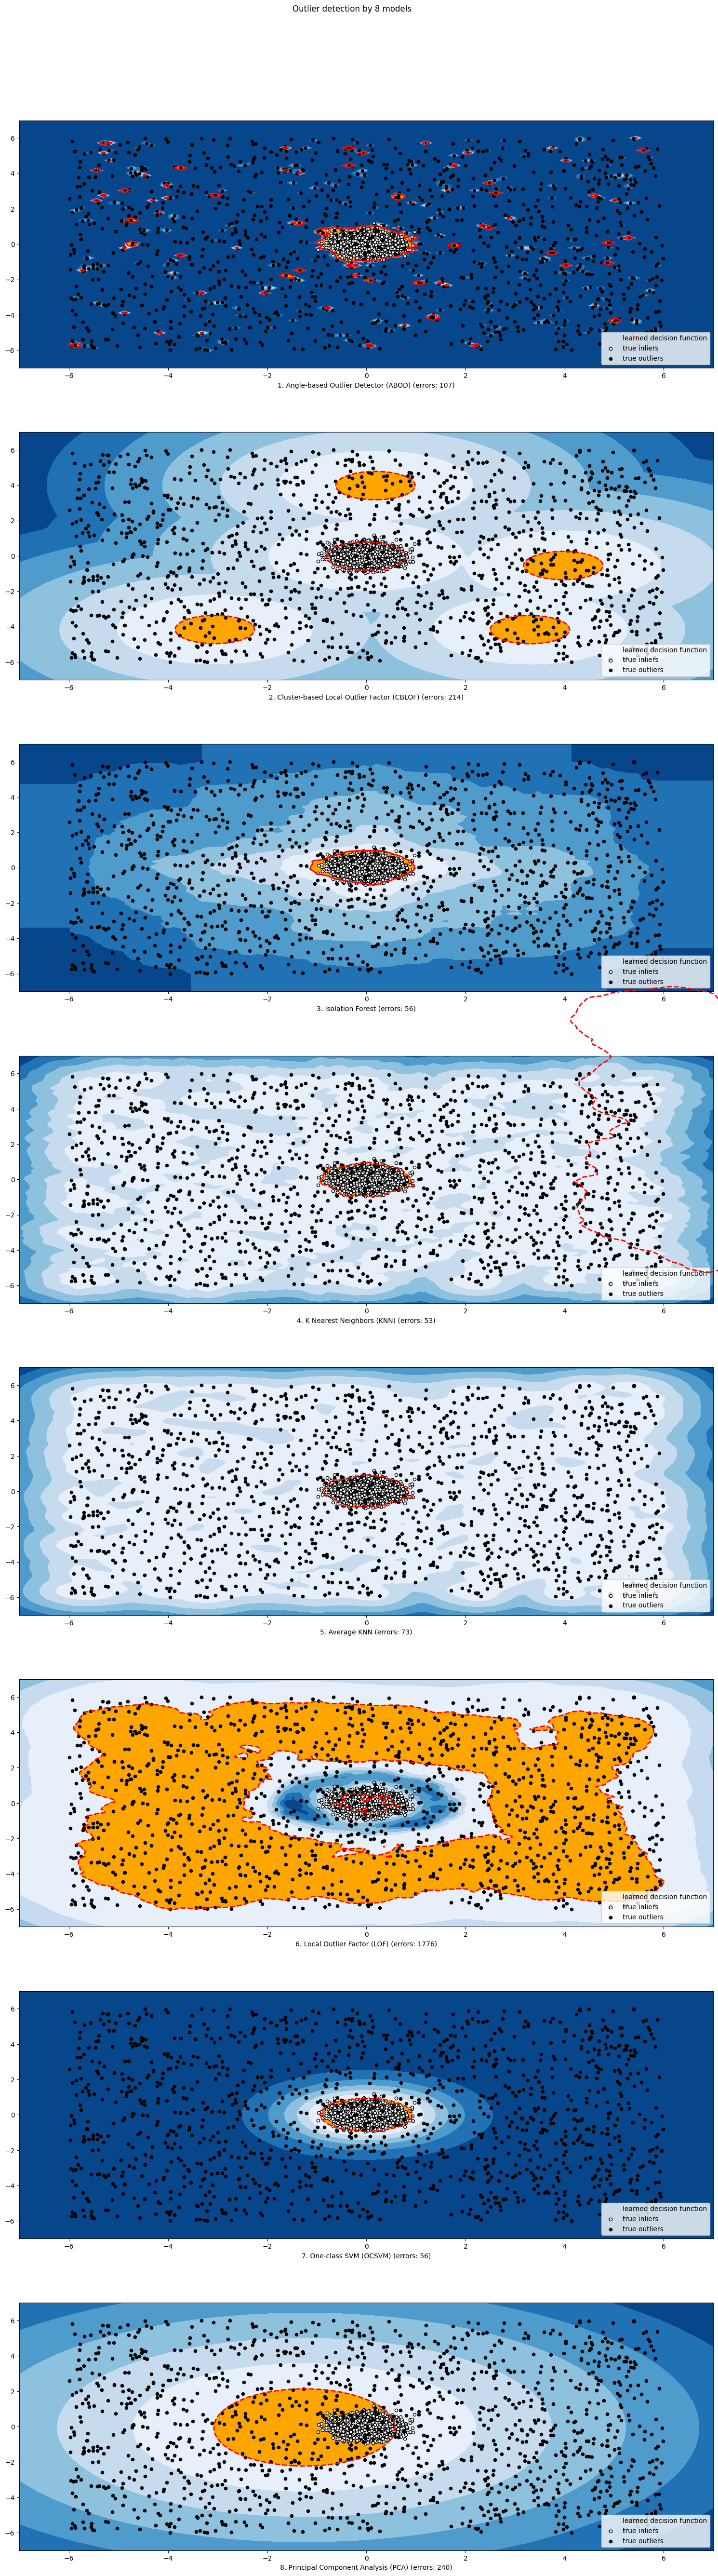

In [10]:
# Fit the models with the generated data and 
# compare model performances
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(num_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(num_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(num_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(15, 60))
    for i, (classifier_name, classifier) in enumerate(clf.items()):
        #print(i + 1, 'fitting', classifier_name)
        # fit the data and tag outliers
        classifier.fit(X)
        scores_pred = classifier.decision_function(X) * -1
        y_pred = classifier.predict(X)
        threshold = percentile(scores_pred, 100 * out_frac)
        num_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points

        Z = classifier.decision_function(np.c_[x.ravel(), y.ravel()]) * -1
        Z = Z.reshape(x.shape)
        subplot = plt.subplot(8, 1, i + 1)
        subplot.contourf(x, y, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(x, y, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(x, y, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-num_outliers, 0], X[:-num_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-num_outliers:, 0], X[-num_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, classifier_name, num_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 1.00, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection by 8 models")
plt.show()